In [23]:
!pip install --upgrade gspread gspread-dataframe --quiet
!pip install evaluate --quiet
!pip install rouge_score --quiet
!python -m spacy download en_core_web_lg --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import numpy as np
import pandas as pd
import regex as re
import time
from google.colab import files
from google.colab import drive

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

!pip install altair_data_server --quiet
import altair as alt
from altair_data_server import data_server

import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
from gspread_dataframe import set_with_dataframe
from gspread_dataframe import get_as_dataframe

import evaluate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
drive.mount('/content/drive')

# data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/12p_BTcxh-mHOfHubfLTUQJ988GOBdC7vbcuiQRGyiHI/edit?gid=0#gid=0')
# raw_data_worksheet = data_spreadsheet.worksheet("Baseline")
# highlights_df = get_as_dataframe(raw_data_worksheet, evaluate_formulas=True)

# # highlights_df = pd.read_csv('/content/drive/MyDrive/266 Final Project/Stage 2/raw_highlights.csv')

# print(len(highlights_df))
# highlights_df.head()

################ GET TEST DATA ########################
test_data_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Uho60wnU9C-cLqUBC3VM4v0Q_S9I4DRMvmcEspdK4U8/edit?gid=338078967#gid=338078967')
test_data_worksheet = test_data_spreadsheet.get_worksheet(0)
test_data_df = get_as_dataframe(test_data_worksheet, evaluate_formulas=True)

test_data_df = test_data_df[test_data_df['paraphrase'].isna()==False].reset_index(drop=True)
test_data_df = test_data_df.drop(columns=['label'])

print(len(test_data_df))
test_data_df.head()

Mounted at /content/drive
1196


,service_id,service_name,doc_type,doc_text,highlight,paraphrase
0,264.0,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...
1,616.0,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...
2,403.0,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time
3,2947.0,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...
4,2544.0,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...


In [ ]:
# highlights_df = highlights_df[['service_id', 'service_name', 'segment_name', 'highlight', 'paraphrase', 'highlight_link']]

In [5]:
t5_small_output_spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1BWEHnuRuwHRpkSL_06Rx26p4TktH_vul4bVg_DMBYKw/edit?pli=1&gid=1964830593#gid=1964830593')
baseline_worksheet = t5_small_output_spreadsheet.worksheet('Baseline')

# T5 Baseline Model

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

def paraphrase_text(input_text, base_model_name="t5-small"):
    """Paraphrase text using the base T5 model without additional pretraining or fine-tuning."""
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the base model and tokenizer from Hugging Face's model hub
    tokenizer = T5Tokenizer.from_pretrained(base_model_name)
    model = T5ForConditionalGeneration.from_pretrained(base_model_name).to(device)

    # Tokenize the input text
    inputs = tokenizer(
        "paraphrase: " + input_text,
        return_tensors="pt",
        max_length=128,
        truncation=True
    ).to(device)

    # Generate paraphrased output
    outputs = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Example usage
print("Original Highlight:", test_data_df['highlight'][21])
print("Generated Paraphrase:", paraphrase_text(test_data_df['highlight'][21]))

Original Highlight: We will notify you when we are asked to hand over your personally identifiable information in this way unless we are legally prohibited from doing so.
Generated Paraphrase: Paraphrase: We will notify you when we are asked to hand over your personally identifiable information in this way unless we are legally prohibited from doing so.


In [ ]:
!pip install evaluate --quiet
!pip install rouge_score --quiet
!pip install bert-score --quiet
!pip install safetensors --quiet
!python -m spacy download en_core_web_lg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import evaluate
from bert_score import score
from nltk.translate.bleu_score import sentence_bleu
import spacy
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method1

nlp = spacy.load("en_core_web_lg")
rouge = evaluate.load("rouge")

In [ ]:
import logging

# Suppress warnings from the transformers library
logging.getLogger("transformers").setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="spacy")
warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

In [ ]:
for index, row in test_data_df.iterrows():
    original_highlight = row['highlight']
    segment_name = row['doc_type']

    # Generate paraphrase using your paraphrasing function
    generated_paraphrase = paraphrase_text(original_highlight)

    # Calculate BERTScore
    P, R, F1 = score(
        [generated_paraphrase],
        [original_highlight],
        lang="en"
    )
    bert_score = F1.item()

    # Calculate ROUGE scores
    rouge_score = rouge.compute(
        predictions=[generated_paraphrase],
        references=[original_highlight]
    )

    # Calculate BLEU score with smoothing
    bleu_score = sentence_bleu(
        [original_highlight.split()],
        generated_paraphrase.split(),
        smoothing_function=smooth_fn
    )

    # Calculate spaCy similarity
    original_doc = nlp(original_highlight)
    generated_doc = nlp(generated_paraphrase)
    spacy_similarity = original_doc.similarity(generated_doc)

    # Store results in the DataFrame
    test_data_df.at[index, 'generated_paraphrase'] = generated_paraphrase
    test_data_df.at[index, 'bert_score'] = bert_score
    test_data_df.at[index, 'rouge_1'] = rouge_score['rouge1']
    test_data_df.at[index, 'rouge_2'] = rouge_score['rouge2']
    test_data_df.at[index, 'rouge_l'] = rouge_score['rougeL']
    test_data_df.at[index, 'bleu_score'] = bleu_score
    test_data_df.at[index, 'spacy_similarity'] = spacy_similarity

    # Push to Google Sheets every 25 rows
    if index % 25 == 0 and index != 0:
        set_with_dataframe(baseline_worksheet, test_data_df)
        time.sleep(10)

# Final push to Google Sheets
set_with_dataframe(baseline_worksheet, test_data_df)

<ipython-input-21-ca88f7176b22>:32: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  spacy_similarity = original_doc.similarity(generated_doc)


In [ ]:
# # Iterate through all rows
# for index, row in test_data_df.iterrows():
#     original_highlight = row['highlight']

#     generated_paraphrase = paraphrase_text(original_highlight)
#     test_data_df.at[index, 'generated_paraphrase'] = generated_paraphrase

#     # set to google sheets every 25 rows
#     if index % 25 == 0: #and index != 0:
#         set_with_dataframe(baseline_worksheet, test_data_df)
#         time.sleep(10)

# # Write the DataFrame to the Google Sheet
# set_with_dataframe(baseline_worksheet, test_data_df)

In [ ]:
test_data_df.head()

,service_id,service_name,segment_name,highlight,paraphrase,highlight_link
0,1946,Telegram,Terms of Service,We reserve the right to update these Terms of ...,Terms may be changed any time at their discre...,https://edit.tosdr.org/points/8167
1,327,Telegram,Privacy Policy,"If collected, this metadata can be kept for 12...",User logs are deleted after a finite period of...,https://edit.tosdr.org/points/8854
2,511,Telegram,Privacy Policy,Secret chats use end-to-end encryption.\nThis ...,"Secret chats content is encrypted, and this se...",https://edit.tosdr.org/points/17472
3,230,Telegram,Privacy Policy,"Deleting your account removes all messages, me...",You can delete your content from this service,https://edit.tosdr.org/points/17480
4,460,Telegram,Privacy Policy,You have a right to: (1) request a copy of all...,You can request access and deletion of persona...,https://edit.tosdr.org/points/11971


# Evaluation

In [8]:
baseline_worksheet = t5_small_output_spreadsheet.worksheet('Baseline')
results_df = get_as_dataframe(baseline_worksheet, evaluate_formulas=True)
results_df.head()

,service_id,service_name,doc_type,doc_text,highlight,paraphrase,generated_paraphrase,bert_score,rouge_1,rouge_2,rouge_l,bleu_score,spacy_similarity
0,264,VKontakte,Privacy Policy,You should not share your credentials with thi...,You should not share your credentials with thi...,You are responsible for maintaining the securi...,Paraphrase,0.737128,0.000000,0.000000,0.000000,0.000000,0.121759
1,616,Pornhub,Terms & Conditions,You are fully responsible for all activities t...,You are fully responsible for all activities t...,You are responsible for maintaining the securi...,Paraphrase: You are fully responsible for all ...,0.946389,0.866667,0.785714,0.866667,0.724158,0.977862
2,403,Fur Affinity,Terms of Service,We retain the right to create limits on our se...,"We may change, suspend, or discontinue any or ...",They may stop providing the service at any time,False,0.784314,0.000000,0.000000,0.000000,0.000000,0.113361
3,2947,Skillshare,Terms of Service,We have the right to terminate your membership...,We have the right to terminate your membership...,Your account can be deleted without prior noti...,False,0.785310,0.000000,0.000000,0.000000,0.000000,0.087854
4,2544,El País,Privacy Policy,Se recomienda que el usuario facilite toda la ...,El Usuario tendr derecho a formular una queja ...,A complaint mechanism is provided for the hand...,El Usuario tendr derecho a formular una queja ...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Rouge

In [9]:
# Load the metric
rouge = evaluate.load("rouge")

# Compute ROUGE scores
results = rouge.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

print(results)

{'rouge1': 0.059640252571031616, 'rouge2': 0.012004771748765866, 'rougeL': 0.04883442892699357, 'rougeLsum': 0.04890625062264316}


*	ROUGE-1: Measures unigram (word-level) overlap.
  *	Good range: 0.4–0.6 or higher.
*	ROUGE-2: Measures bigram (two-word sequence) overlap.
  *	Good range: 0.2–0.4 or higher.
*	ROUGE-L: Measures the longest common subsequence (focuses on fluency and structure).
  *	Good range: 0.3–0.5 or higher.

## Bleu

In [15]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Smoothing function
smooth_fn = SmoothingFunction().method1

# Prepare tokenized references and candidates
references = [[ref.split()] for ref in results_df['paraphrase'].tolist()]
candidates = [str(cand).split() for cand in results_df['generated_paraphrase'].tolist()]

# Compute BLEU score
overall_bleu_score = corpus_bleu(references, candidates, smoothing_function=smooth_fn)

# Print the overall BLEU score
print(f"Overall BLEU Score: {overall_bleu_score:.4f}")

Overall BLEU Score: 0.0087


## Mereor

In [16]:
# Load METEOR metric
meteor = evaluate.load("meteor")

# Compute METEOR scores
results = meteor.compute(
    predictions=results_df['generated_paraphrase'].tolist(),
    references=results_df['paraphrase'].tolist()
)

# Print the results
print(results)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.05916749689715077}


## BERT

In [17]:
!pip install bert-score --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.6 MB/s eta 0:00:00


In [21]:
from bert_score import score

P, R, F1 = score(
    results_df['generated_paraphrase'].astype(str).tolist(),
    results_df['paraphrase'].astype(str).tolist(),
    lang="en"
)

results_df['BERTScore P<>GP'] = F1.numpy()

overall_bert_score = F1.mean().item()
print(f"Overall BERTScore P<>GP (F1): {overall_bert_score:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall BERTScore (F1): 0.8105


## SpaCy
fact checking

In [24]:
import spacy

# Load the spaCy model (use a model with word vectors, e.g., 'en_core_web_md' or 'en_core_web_lg')
nlp = spacy.load("en_core_web_lg")

# Ensure all values are strings
generated_paraphrases = results_df['generated_paraphrase'].astype(str).tolist()
paraphrases = results_df['paraphrase'].astype(str).tolist()

# Calculate spaCy similarity for each pair
spacy_scores = []

for gen, ref in zip(generated_paraphrases, paraphrases):
    gen_doc = nlp(gen)
    ref_doc = nlp(ref)
    similarity = gen_doc.similarity(ref_doc)
    spacy_scores.append(similarity)

# Add individual spaCy scores to the DataFrame
results_df['spaCy Similarity'] = spacy_scores

# Compute the overall spaCy similarity score
overall_spacy_score = sum(spacy_scores) / len(spacy_scores)

print(f"Overall spaCy Similarity Score: {overall_spacy_score:.4f}")

<ipython-input-24-21e77751ea57>:16: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = gen_doc.similarity(ref_doc)


Overall spaCy Similarity Score: 0.3343


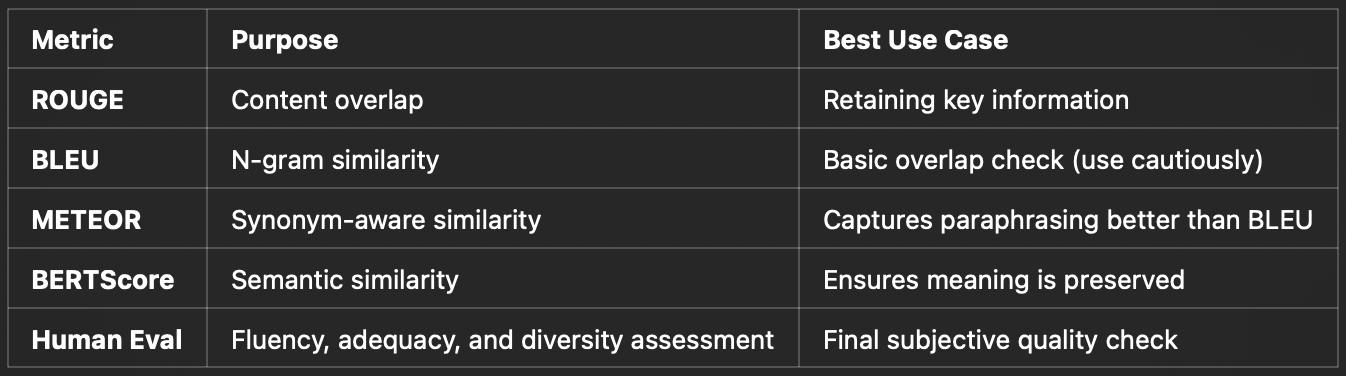

# Analysis

In [ ]:
gen_data_df.head()

,service_id,service_name,segment_name,highlight,paraphrase,highlight_link,generated_paraphrase,BLEU,BERTScore P<>GP,BERTScore H<>GP
0,969,ToS;DR Phoenix,Privacy Policy,We do not sell your data.,Your personal data is not sold,https://edit.tosdr.org/points/19493,This service does not sell your personal data,0.065006,0.937363,0.955330
1,306,Mega,Terms,we will also terminate your account if we cons...,User accounts can be terminated after having b...,https://edit.tosdr.org/points/25755,This service may terminate your account if you...,0.012205,0.892263,0.949784
2,251,Foursquare,Terms of Use,You must be at least 13 years of age to access...,This service is only available to users over a...,https://edit.tosdr.org/points/17164,You must be at least 13 years of age,0.019202,0.868494,0.948709
3,1607,credit_karma,Terms of Service,You must comply with all applicable laws when ...,Users agree to comply with the law of the serv...,https://edit.tosdr.org/points/9352,You must comply with all applicable laws,0.039447,0.914654,0.946639
4,2371,Vivaldi,End User License Agreement,You may only use the Software and Services for...,This service is only available for use individ...,https://edit.tosdr.org/points/11212,You can use the service for personal use,0.028469,0.860383,0.941764


In [ ]:
data_spreadsheet = gc.open_by_url("https://docs.google.com/spreadsheets/d/12p_BTcxh-mHOfHubfLTUQJ988GOBdC7vbcuiQRGyiHI/edit?gid=0#gid=0")
mapping_ws = data_spreadsheet.worksheet("Type Mapping")
mapping_df = get_as_dataframe(mapping_ws, evaluate_formulas=True)
mapping_df.head()

,segment_name,segment_type
0,Content Policy,Other
1,Digital Millennium Copyright Act (DMCA) Notic...,Other
2,Terms and Conditions,Terms
3,2FA,Other
4,About Cookies,Cookie Policy


In [ ]:
gen_analysis_df = gen_data_df.merge(mapping_df, on="segment_name", how="left")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

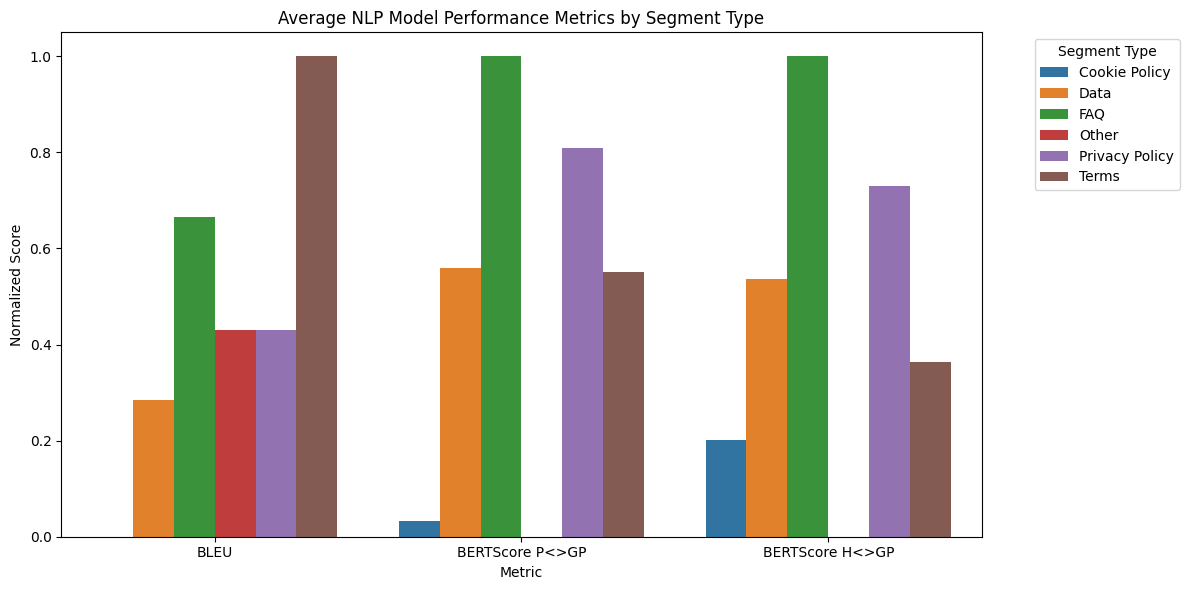

In [ ]:
# Group the data by segment_name and calculate mean scores
grouped_segment_df = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Normalize scores for better visualization
grouped_segment_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]] = scaler.fit_transform(
    grouped_segment_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]]
)

# Melt the DataFrame for easier plotting
melted_segment_df = grouped_segment_df.melt(
    id_vars=["segment_type"],
    value_vars=["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"],
    var_name="Metric",
    value_name="Score"
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_segment_df, x="Metric", y="Score", hue="segment_type")

plt.title("Average NLP Model Performance Metrics by Segment Type")
plt.xlabel("Metric")
plt.ylabel("Normalized Score")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

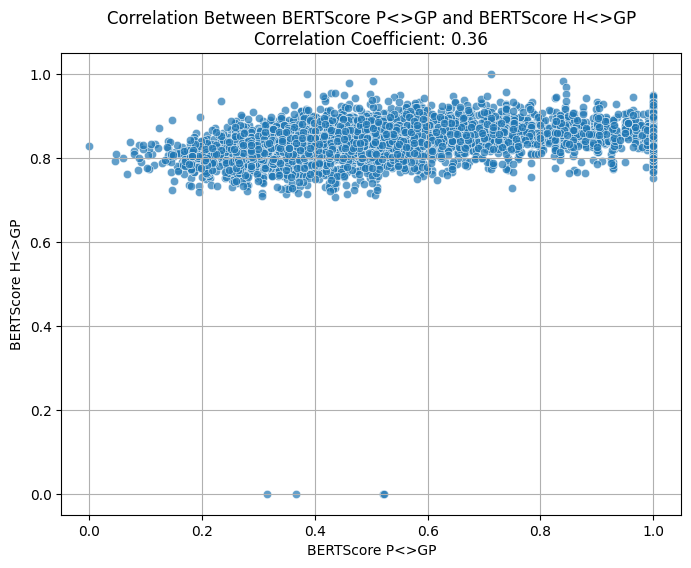

In [ ]:
# Calculate correlation between the two BERT scores
correlation = gen_analysis_df["BERTScore P<>GP"].corr(gen_analysis_df["BERTScore H<>GP"])

# Plot correlation
plt.figure(figsize=(8, 6))
sns.scatterplot(data=gen_analysis_df, x="BERTScore P<>GP", y="BERTScore H<>GP", alpha=0.7)
plt.title(f"Correlation Between BERTScore P<>GP and BERTScore H<>GP\nCorrelation Coefficient: {correlation:.2f}")
plt.xlabel("BERTScore P<>GP")
plt.ylabel("BERTScore H<>GP")
plt.grid(True)
plt.show()

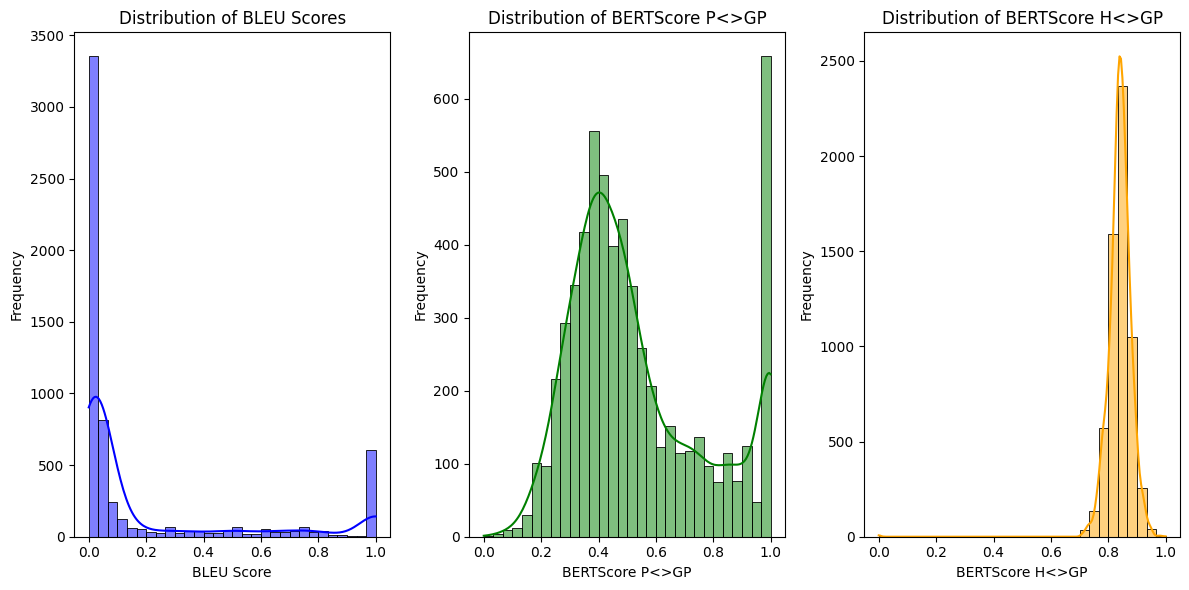

In [ ]:
# Plot the distribution of BLEU and BERT scores
plt.figure(figsize=(12, 6))

# BLEU Score Distribution
plt.subplot(1, 3, 1)
sns.histplot(gen_analysis_df["BLEU"], kde=True, bins=30, color="blue")
plt.title("Distribution of BLEU Scores")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")

# BERTScore P<>GP Distribution
plt.subplot(1, 3, 2)
sns.histplot(gen_analysis_df["BERTScore P<>GP"], kde=True, bins=30, color="green")
plt.title("Distribution of BERTScore P<>GP")
plt.xlabel("BERTScore P<>GP")
plt.ylabel("Frequency")

# BERTScore H<>GP Distribution
plt.subplot(1, 3, 3)
sns.histplot(gen_analysis_df["BERTScore H<>GP"], kde=True, bins=30, color="orange")
plt.title("Distribution of BERTScore H<>GP")
plt.xlabel("BERTScore H<>GP")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

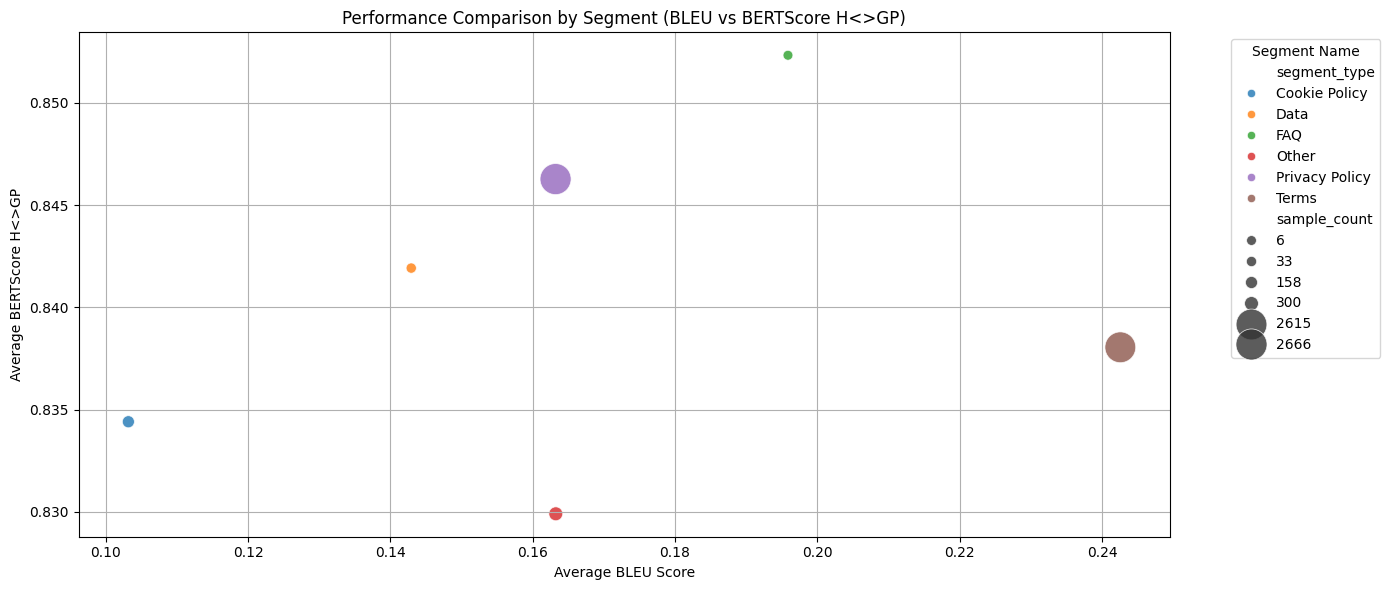

In [ ]:
# Count the number of rows (samples) per segment_name
segment_sample_counts = gen_analysis_df["segment_type"].value_counts().reset_index()
segment_sample_counts.columns = ["segment_type", "sample_count"]

# Calculate the mean scores for each segment
segment_performance = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Merge the sample counts with performance data
segment_performance = segment_performance.merge(segment_sample_counts, on="segment_type")

# Plot performance comparison
plt.figure(figsize=(14, 6))

# Scatter plot with sample count as marker size
sns.scatterplot(
    data=segment_performance,
    x="BLEU",
    y="BERTScore H<>GP",
    size="sample_count",
    hue="segment_type",
    sizes=(50, 500),
    alpha=0.8
)

plt.title("Performance Comparison by Segment (BLEU vs BERTScore H<>GP)")
plt.xlabel("Average BLEU Score")
plt.ylabel("Average BERTScore H<>GP")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

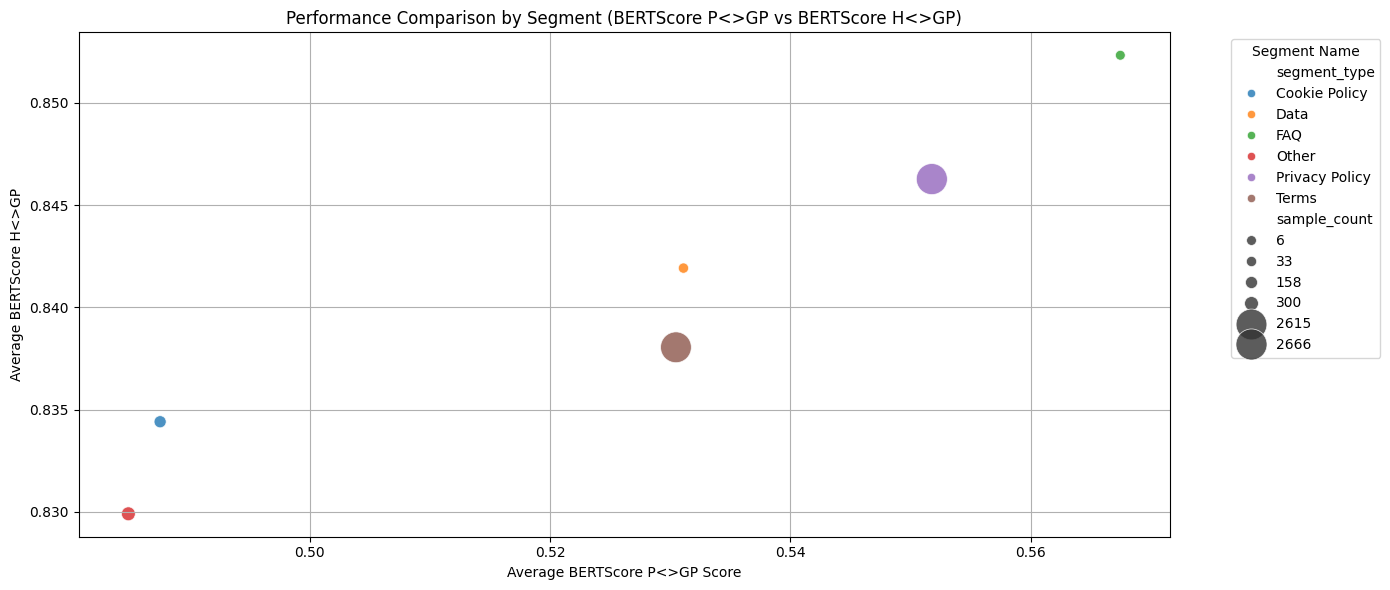

In [ ]:
# Count the number of rows (samples) per segment_name
segment_sample_counts = gen_analysis_df["segment_type"].value_counts().reset_index()
segment_sample_counts.columns = ["segment_type", "sample_count"]

# Calculate the mean scores for each segment
segment_performance = gen_analysis_df.groupby("segment_type")[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]].mean().reset_index()

# Merge the sample counts with performance data
segment_performance = segment_performance.merge(segment_sample_counts, on="segment_type")

# Plot performance comparison
plt.figure(figsize=(14, 6))

# Scatter plot with sample count as marker size
sns.scatterplot(
    data=segment_performance,
    x="BERTScore P<>GP",
    y="BERTScore H<>GP",
    size="sample_count",
    hue="segment_type",
    sizes=(50, 500),
    alpha=0.8
)

plt.title("Performance Comparison by Segment (BERTScore P<>GP vs BERTScore H<>GP)")
plt.xlabel("Average BERTScore P<>GP Score")
plt.ylabel("Average BERTScore H<>GP")
plt.legend(title="Segment Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

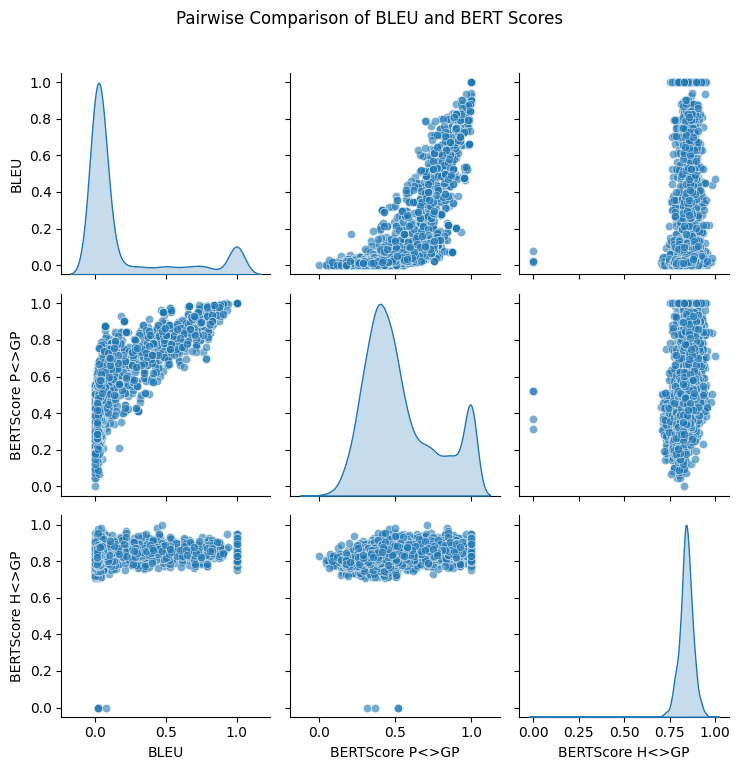

In [ ]:
# Create a pairplot to compare BLEU, BERTScore P<>GP, and BERTScore H<>GP
sns.pairplot(
    gen_analysis_df[["BLEU", "BERTScore P<>GP", "BERTScore H<>GP"]],
    kind="scatter",
    diag_kind="kde",
    plot_kws={"alpha": 0.6}
)

plt.suptitle("Pairwise Comparison of BLEU and BERT Scores", y=1.02)
plt.tight_layout()
plt.show()

# Next Steps

1. X Pull more training data (195 services)
2. Clean highlight (punctuation, spaces, etc.) the same as done in TOS
3. Adjust Model

  a. Number of Epochs (currently 3)

  b. Adjust learning rate
  
  c. Adjust Batch Size (currently 4)
  
  d. Adjust Token Limit (currently 128)
4. Evaluate based on different segments (privacy policies, FAQ, etc)
5. Add context to the statement ("paraphrase this privacy policy statement: " + highlight) - look at t5 prompts that work
6. Use a larger model or find a domain specific model (t5, pegasus, gpt)
7. Add in reinforcement learning
8. Use BERT score against the original to retry
9. Ensemble Models
10. Check factual consistency